Name : Mai Phuong Nguyen

Student ID: 587089



# Lab 2 :  Recurrent Neural Networks Task


**For each task, train and validate the following models**

1.  RNN - the simplest RNN architecture implemented and trained by yourself from scratch.
2.   GRU - GRU net implemented and trained by yourself from scratch.     Hint: try 2 GRU layers
3. LSTM - GRU net implemented and trained by yourself from scratch.      Hint: try 2 LSTM layers

Perform sentiment analysis to predict the sentiments
concerning overall satisfaction, side effects, and effectiveness of user reviews on specific drugs.



**Predict overall rating (druglib.com)**
- RNN
- GRU
- LSTM

**Predict effectiveness/Benefits (druglib.com)**
- RNN
- GRU
- LSTM


**Required outcomes (Jupyter Notebook):**

- Trained models: 6 models (2 RNN, 2 GRU, 2 LSTM) for 2 objectives (predict overall rating, predict effectiveness)

- For every model: the following metrics are calculated/plotted: accuracy, balanced_accuracy, f1, roc_auc, precision, recall, and confusion matrix. For more details, please check:  Metrics and scoring: quantifying the quality of predictions

- For every model/experiment: Learning curves for the loss function (weighted kappa, BinaryLogLoss, or CategoricalCrossEntropy) are plotted. The train learning curves must be in blue and the test curves must be in red.

In [1]:
!pip install keras

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout,
    Bidirectional, BatchNormalization
)


import re

# 1. Reading the data and prepare them

In [10]:


df_train = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
df_test = pd.read_csv('drugLibTest_raw.tsv', sep='\t')


df_train['commentsReview'] = df_train['commentsReview'].astype(str).fillna('')
df_test['commentsReview'] = df_test['commentsReview'].astype(str).fillna('')

X_train = df_train['commentsReview']
y_train_rating = df_train['rating']
y_train_effectiveness = df_train['effectiveness']

X_test = df_test['commentsReview']
y_test_rating = df_test['rating']
y_test_effectiveness = df_test['effectiveness']

df_test.head(5)






,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...
4,696,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...


# 2. Label Encoding


In [11]:
le_rating = LabelEncoder()
y_train_rating = le_rating.fit_transform(y_train_rating)
y_test_rating = le_rating.transform(y_test_rating)

le_effectiveness = LabelEncoder()
y_train_effectiveness = le_effectiveness.fit_transform(y_train_effectiveness)
y_test_effectiveness = le_effectiveness.transform(y_test_effectiveness)

# 3. Tokenize and convert our data to sequences (-> RNNs work better with sequences) and pad them

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1

# 4. Building first simple RNN

In [13]:
#https://stackoverflow.com/questions/78911076/why-does-my-simplernn-model-in-sequential-api-show-for-output-shape-and-zero
#https://medium.com/@pmaruthiprasad16/end-to-end-deep-learning-project-using-simple-rnn-8b0b048ce975'

def create_rnn_model(in_leng, vocab_size, num_classes, embedding_dim=100, rnn_units=64):
    """
    Shorter SimpleRNN model, no pooling.
    - Bidirectional SimpleRNN with return_sequences=False.
    - Dropout and recurrent_dropout in SimpleRNN.
    - Simpler Dense head.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=in_leng,
                  mask_zero=True),  # Important to ignore padding

        Bidirectional(SimpleRNN(rnn_units,
                                # return_sequences=False by default if it's the last RNN layer
                                # before a Dense layer that doesn't expect sequences.
                                # Explicitly: return_sequences=False,
                                dropout=0.2,
                                recurrent_dropout=0.2)),

        Dense(64, activation='relu'),
        # BatchNormalization(), # Can be optional for very short models
        Dropout(0.4),

        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 5. GRU Model

In [14]:
def create_gru_model(in_leng, vocab_size, num_classes, embedding_dim=100, gru_units_1=64, gru_units_2=32):
    """
    Shorter GRU model, no pooling.
    - Stacked Bidirectional GRU layers, last one with return_sequences=False.
    - Dropout and recurrent_dropout in GRU layers.
    - Simpler Dense head.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=in_leng,
                  mask_zero=True),

        Bidirectional(GRU(gru_units_1,
                          return_sequences=True,  # True because another GRU layer follows
                          dropout=0.3,
                          recurrent_dropout=0.3)),

        Bidirectional(GRU(gru_units_2,
                          # return_sequences=False for the last RNN before Dense head
                          dropout=0.3,
                          recurrent_dropout=0.3)),

        Dense(64, activation='relu'),
        # BatchNormalization(),
        Dropout(0.4),

        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 6. LSTM Model

In [15]:
def create_lstm_model(in_leng, vocab_size, num_classes, embedding_dim=100, lstm_units_1=64, lstm_units_2=32):
    """
    Shorter LSTM model, no pooling.
    - Stacked Bidirectional LSTM layers, last one with return_sequences=False.
    - Dropout and recurrent_dropout in LSTM layers.
    - Simpler Dense head.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=in_leng,
                  mask_zero=True),

        Bidirectional(LSTM(lstm_units_1,
                           return_sequences=True, # True because another LSTM layer follows
                           dropout=0.3,
                           recurrent_dropout=0.3)),

        Bidirectional(LSTM(lstm_units_2,
                           # return_sequences=False for the last RNN before Dense head
                           dropout=0.3,
                           recurrent_dropout=0.3)),

        Dense(64, activation='relu'),
        # BatchNormalization(),
        Dropout(0.4),

        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 7. Train all models

In [16]:
models = {
    'rnn_rating': create_rnn_model(100, vocab_size, len(le_rating.classes_)),
    'gru_rating': create_gru_model(100, vocab_size, len(le_rating.classes_)),
    'lstm_rating': create_lstm_model(100, vocab_size, len(le_rating.classes_)),
    'rnn_effectiveness': create_rnn_model(100, vocab_size, len(le_effectiveness.classes_)),
    'gru_effectiveness': create_gru_model(100, vocab_size, len(le_effectiveness.classes_)),
    'lstm_effectiveness': create_lstm_model(100, vocab_size, len(le_effectiveness.classes_))
}



history = {}
for rnn_mod, model in models.items():
    if 'rating' in rnn_mod:
        history[rnn_mod] = model.fit(X_train_pad, y_train_rating, epochs=3, validation_data=(X_test_pad, y_test_rating))
    else:
        history[rnn_mod] = model.fit(X_train_pad, y_train_effectiveness, epochs=3, validation_data=(X_test_pad, y_test_effectiveness))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.1263 - loss: 2.3385 - val_accuracy: 0.2191 - val_loss: 2.1588
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.2232 - loss: 2.1493 - val_accuracy: 0.1824 - val_loss: 2.1690
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.2169 - loss: 2.1384 - val_accuracy: 0.2181 - val_loss: 2.1397
Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 567ms/step - accuracy: 0.2090 - loss: 2.1989 - val_accuracy: 0.2181 - val_loss: 2.1220
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step - accuracy: 0.2440 - loss: 2.0584 - val_accuracy: 0.2297 - val_loss: 2.1114
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 514ms/step - accuracy: 0.2641 - loss: 1.9054 - val_accuracy: 0.2230 - val_loss: 2.1293
Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 623ms/step - accuracy: 0.2015 - loss: 2.2213 - val_accuracy: 0.2181 - val_loss: 2.1299
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 565ms/step - accuracy: 0.2385 - loss: 2.0748 - val_accuracy: 0.

# 8. Create Function to evaluate the models

In [28]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    if y_pred.shape[1] > 1:
        # Multi-class classification
        y_pred_classes = y_pred.argmax(axis=1)
        roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')
    else:
        # Binary classification
        y_pred_classes = (y_pred > 0.5).astype("int32")
        roc_auc = roc_auc_score(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred_classes)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_test, y_pred_classes)

    return accuracy, balanced_accuracy, f1, roc_auc, precision, recall, cm

# 9. Create Function to plot learning curves

In [29]:
def plot_learning_curves(history_object, rnn_mod):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_object.history['loss'], label='train loss', color='blue')
    plt.plot(history_object.history['val_loss'], label='val loss', color='red')
    plt.title(f'{rnn_mod} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_object.history['accuracy'], label='train accuracy', color='blue')
    plt.plot(history_object.history['val_accuracy'], label='val accuracy', color='red')
    plt.title(f'{rnn_mod} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 10. start evaluating process

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


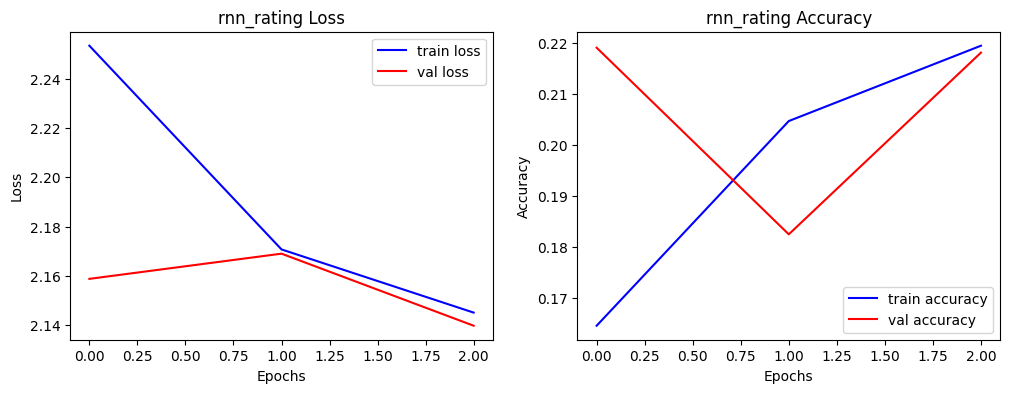

rnn_rating Metrics:
Accuracy: 0.21814671814671815
Balanced Accuracy: 0.1
F1 Score: 0.07813178811594025
ROC AUC: 0.5090902059782901
Precision: 0.04758799063818369
Recall: 0.21814671814671815
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0 115]
 [  0   0   0   0   0   0   0   0   0  33]
 [  0   0   0   0   0   0   0   0   0  49]
 [  0   0   0   0   0   0   0   0   0  44]
 [  0   0   0   0   0   0   0   0   0  67]
 [  0   0   0   0   0   0   0   0   0  58]
 [  0   0   0   0   0   0   0   0   0 121]
 [  0   0   0   0   0   0   0   0   0 190]
 [  0   0   0   0   0   0   0   0   0 133]
 [  0   0   0   0   0   0   0   0   0 226]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step


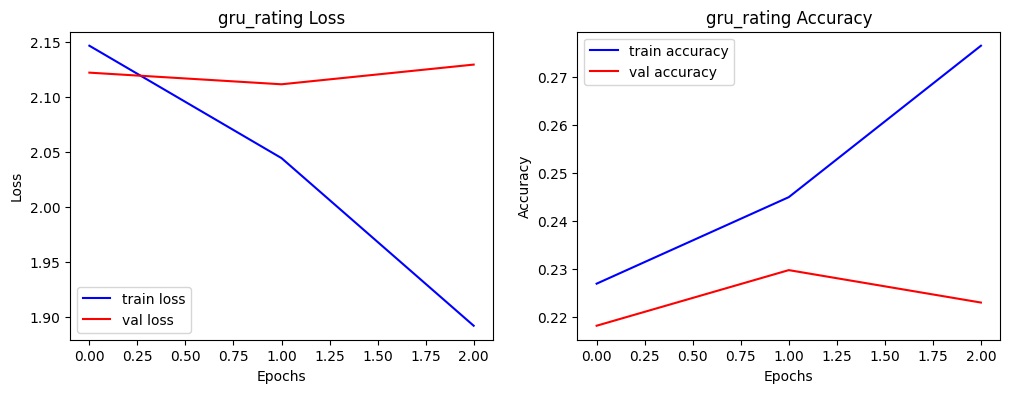

gru_rating Metrics:
Accuracy: 0.22297297297297297
Balanced Accuracy: 0.13141106903464897
F1 Score: 0.1540519283230233
ROC AUC: 0.5900361363155487
Precision: 0.1190463306323002
Recall: 0.22297297297297297
Confusion Matrix:
[[ 56   0   0   0   0   0   1  34   0  24]
 [ 15   0   0   0   0   0   0   9   0   9]
 [ 21   0   0   0   0   0   1  14   0  13]
 [ 15   0   0   0   0   0   0  17   1  11]
 [ 25   0   0   0   0   0   0  22   0  20]
 [ 23   0   0   0   0   0   0  17   2  16]
 [ 41   0   0   0   0   0   0  44   1  35]
 [ 41   0   0   0   0   0   0  63   3  83]
 [ 30   0   0   0   0   0   1  46   0  56]
 [ 44   0   0   0   0   0   0  68   2 112]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step


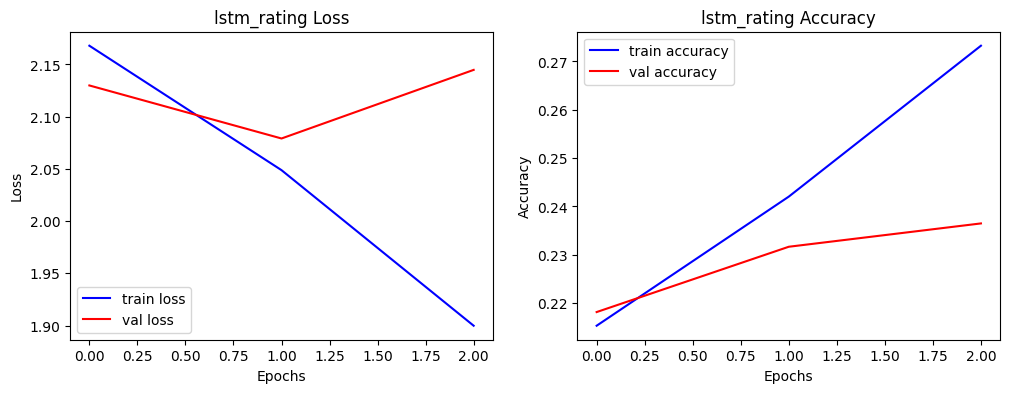

lstm_rating Metrics:
Accuracy: 0.23648648648648649
Balanced Accuracy: 0.13754419955172542
F1 Score: 0.137937986068682
ROC AUC: 0.598843801893273
Precision: 0.14094922484382455
Recall: 0.23648648648648649
Confusion Matrix:
[[ 62   0   0   0   0   0   3   5   1  44]
 [ 20   0   0   0   0   0   0   1   1  11]
 [ 28   0   0   0   0   0   0   3   1  17]
 [ 15   0   0   0   0   0   1   3   0  25]
 [ 21   0   0   0   0   0   2   0   1  43]
 [ 21   0   0   0   0   0   2   2   1  32]
 [ 31   0   0   0   0   0   4  11   5  70]
 [ 44   0   0   0   0   0   4   6   3 133]
 [ 31   0   0   0   0   0   2   6   2  92]
 [ 38   0   0   0   0   0   1  11   5 171]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


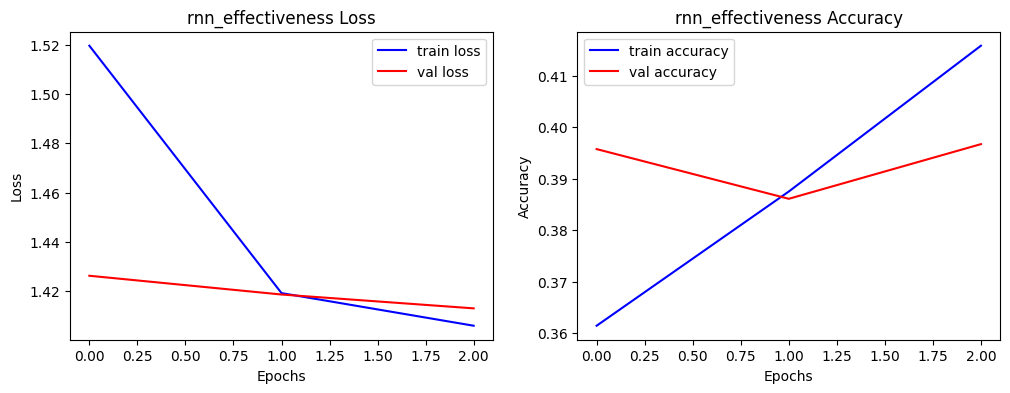

rnn_effectiveness Metrics:
Accuracy: 0.3967181467181467
Balanced Accuracy: 0.2001585432854564
F1 Score: 0.2276460191476135
ROC AUC: 0.4915291544774128
Precision: 0.2077882320600767
Recall: 0.3967181467181467
Confusion Matrix:
[[  1 309   0   0   0]
 [  1 410   0   0   0]
 [  0  82   0   0   0]
 [  0  76   0   0   0]
 [  4 153   0   0   0]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step


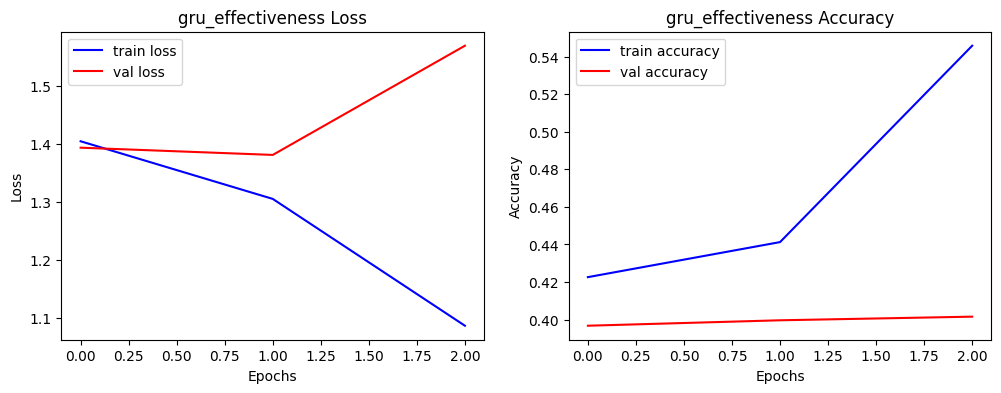

gru_effectiveness Metrics:
Accuracy: 0.4015444015444015
Balanced Accuracy: 0.23383926491313045
F1 Score: 0.32909618829811627
ROC AUC: 0.585964762939
Precision: 0.34011765714827635
Recall: 0.4015444015444015
Confusion Matrix:
[[ 67 231   4   0   8]
 [ 63 330   2   0  16]
 [ 14  54   5   0   9]
 [  9  54   3   0  10]
 [ 25 115   3   0  14]]
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


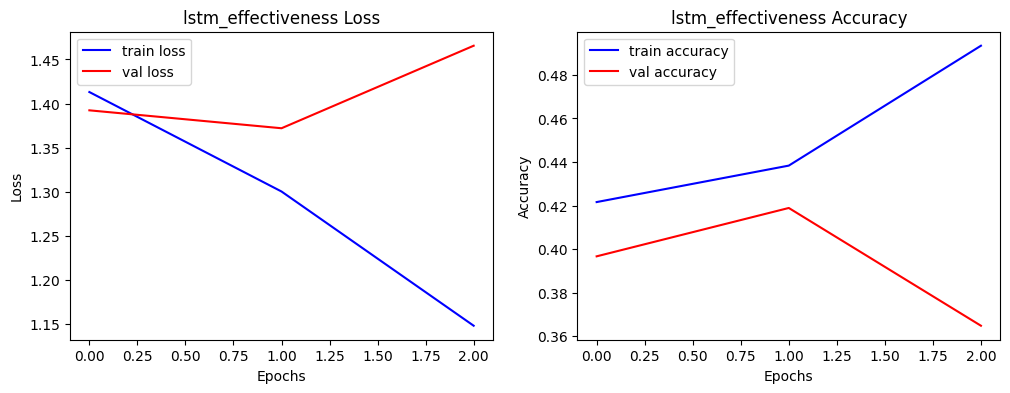

lstm_effectiveness Metrics:
Accuracy: 0.36486486486486486
Balanced Accuracy: 0.23749790696852946
F1 Score: 0.3403362594057946
ROC AUC: 0.5870518491235397
Precision: 0.32064925307187186
Recall: 0.36486486486486486
Confusion Matrix:
[[107 141  13   0  49]
 [139 226   2   0  44]
 [ 31  20   1   0  30]
 [ 35  23   3   0  15]
 [ 57  53   3   0  44]]


In [31]:
results = {}
for rnn_mod, model in models.items():
    if 'rating' in rnn_mod:
        results[rnn_mod] = evaluate_model(model, X_test_pad, y_test_rating)
    else:
        results[rnn_mod] = evaluate_model(model, X_test_pad, y_test_effectiveness)

    plot_learning_curves(history[rnn_mod], rnn_mod)
    metrics = results[rnn_mod]
    print(f'{rnn_mod} Metrics:')
    print(f'Accuracy: {metrics[0]}')
    print(f'Balanced Accuracy: {metrics[1]}')
    print(f'F1 Score: {metrics[2]}')
    print(f'ROC AUC: {metrics[3]}')
    print(f'Precision: {metrics[4]}')
    print(f'Recall: {metrics[5]}')
    print(f'Confusion Matrix:\n{metrics[6]}')

# Extra: acurracy was not so good -> in order to improve -> i have decided to use BERT


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

### 1. Read Data and drop unused columns

In [14]:

# Load data
df_train = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
df_test = pd.read_csv('drugLibTest_raw.tsv', sep='\t')


keep_cols = ['commentsReview', 'rating']
df_train = df_train[keep_cols]
df_test = df_test[keep_cols]



### 2. Label classes based on rating

In [15]:
def rating_class(df):
    df['commentsReview'] = df['commentsReview'].astype(str).str.replace("&#039;", "'")
    df['rating_class'] = 0
    df.loc[df['rating'] >= 7, 'rating_class'] = 2
    df.loc[df['rating'] <= 4, 'rating_class'] = 1
    return df

df_train = rating_class(df_train)
df_test = rating_class(df_test)


print(df_test)

                                         commentsReview  rating  rating_class
0     Took the antibiotics for 14 days. Sinus infect...       9             2
1     Severe mood swings between hypomania and depre...       9             2
2     Depakote was prescribed to me by a Kaiser psyc...       4             1
3     This drug may not be for everyone but its wond...      10             2
4     Drug was taken in gelatin tablet at 0.5 mg per...      10             2
...                                                 ...     ...           ...
1031  Treatment period is 3 months/12 weeks. Dosage ...       7             2
1032  I use the albuterol as needed because of aller...      10             2
1033  This drug is highly teratogenic ,females must ...       8             2
1034  Divigel is a topically applied Bio-Identical H...      10             2
1035               Stopped using it for the time being.       8             2

[1036 rows x 3 columns]


### 3. Prepare labels and tokenize the text

In [16]:
# Prepare labels - use 0,1,2 instead of -1,0,1 for easier handling
y_train = to_categorical(df_train['rating_class'], num_classes=3)
y_test = to_categorical(df_test['rating_class'], num_classes=3)


# Load BERT model and tokenizer
bert = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
max_length = 70

def tokenize_data(texts):
    return tokenizer(
        text=texts.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True
    )

x_train = tokenize_data(df_train['commentsReview'])
x_test = tokenize_data(df_test['commentsReview'])


print(x_test)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': <tf.Tensor: shape=(1036, 70), dtype=int32, numpy=
array([[ 101, 2165, 1996, ...,    0,    0,    0],
       [ 101, 5729, 6888, ..., 2077, 3637,  102],
       [ 101, 2139, 4502, ..., 1045, 2106,  102],
       ...,
       [ 101, 2023, 4319, ...,    0,    0,    0],
       [ 101, 4487, 5737, ..., 1012,  102,    0],
       [ 101, 3030, 2478, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1036, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


### 4. Initialize and build with roberta

In [17]:
# Build model
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Alternative approach using Sequential-style model building
class BertClassifier(tf.keras.Model):
    def __init__(self, bert_model, num_classes=3):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.pooler = GlobalMaxPool1D()
        self.dense1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(32, activation='relu')
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # Get BERT outputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs[0]  # last_hidden_state

        # Classification head
        pooled = self.pooler(sequence_output)
        x = self.dense1(pooled)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.classifier(x)

# Create model
model = BertClassifier(bert)

# Build the model by calling it once
dummy_input = {
    'input_ids': tf.zeros((1, max_length), dtype=tf.int32),
    'attention_mask': tf.zeros((1, max_length), dtype=tf.int32)
}
_ = model(dummy_input)

xd_input = {
    'input_ids': tf.zeros((1, max_length), dtype=tf.int32),
    'attention_mask': tf.zeros((1, max_length), dtype=tf.int32)
}
_=model(xd_input)



### 5. Compile model


In [18]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 128)               │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 3)                 │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,659 (401.01 KB)

 Trainable params: 102,659 (401.01 KB)

 Non-trainable params: 0 (0.00 B)

### 6. train model

In [19]:
history = model.fit(
    x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y=y_train,
    validation_data=({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, y_test),
    epochs=7,
    batch_size=16,
    shuffle=True,
    verbose=1
)

Epoch 1/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.6663 - loss: 0.8582 - val_accuracy: 0.6467 - val_loss: 0.9159
Epoch 2/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.6791 - loss: 0.8275 - val_accuracy: 0.6477 - val_loss: 0.8744
Epoch 3/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6874 - loss: 0.8121 - val_accuracy: 0.6467 - val_loss: 0.8863
Epoch 4/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.6757 - loss: 0.8068 - val_accuracy: 0.6525 - val_loss: 0.8590
Epoch 5/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.6925 - loss: 0.7732 - val_accuracy: 0.6477 - val_loss: 0.8621
Epoch 6/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.6909 - loss: 0.7769 - val_accuracy: 0.6477 - val_loss: 0.8524
Epoch 7/7
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.6967 - loss: 0.7626 - val_accuracy: 0.6506 - val_loss: 0.8343


### 7. predictions

In [20]:
predictions = model.predict({
    'input_ids': x_test['input_ids'],
    'attention_mask': x_test['attention_mask']
})

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step


### 8. evaluate

In [21]:
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")

Accuracy: 0.6506
Precision: 0.4048
Recall: 0.3433
F1 Score: 0.2857


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 9. plot curves

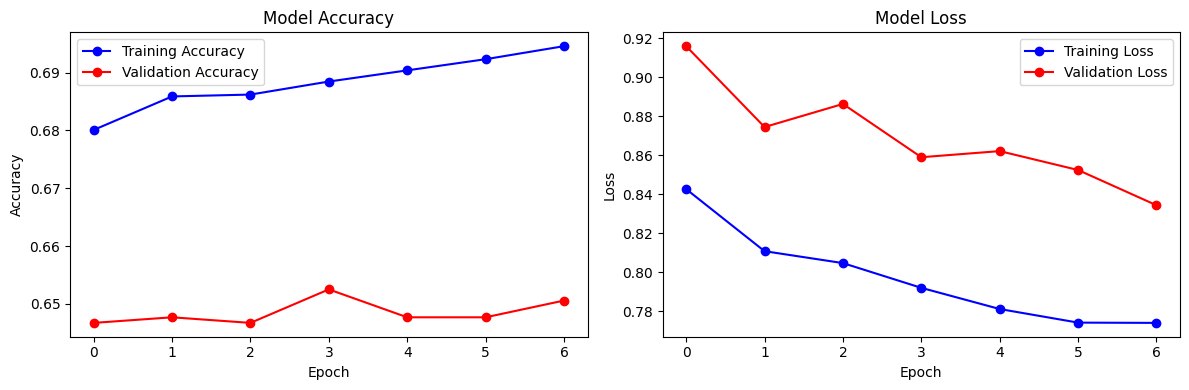

In [22]:
def plot_training_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()


    ax2.plot(history.history['loss'], 'bo-', label='Training Loss')
    ax2.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)